# Experiment 1

The goal of this experiment was to test the policy gradient implementation on a toy problem of learning the identity function defined over an alphabet of discrete symbols. I also compared the policy gradient implementation with supervised learning, played with effects of learning rate, batch size and alphabet size on convergence and explored some ways of visualizing learned codebook.

In [335]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.optim import Adam
import seaborn as sns; sns.set()

torch.manual_seed(1773);

In [336]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Embedding(input_size, output_size)

    def forward(self, input):
        return F.softmax(self.linear(input), dim=1)

In [337]:
class World:
    def __init__(self, batch_size, alphabet_size):
        self.batch_size, self.alphabet_size = batch_size, alphabet_size
        self.reset()
    
    def reset(self):
        self.hidden_state = torch.randint(
            high=self.alphabet_size, 
            size=(self.batch_size,),
            dtype=torch.long
        )
    
    def receive_observation(self):
        return self.hidden_state
    
    def execute_action(self, action):
        return (self.hidden_state == action).float()
    
class Agent:
    
    def __init__(self, alphabet_size, learning_rate):
        self.policy = PolicyNet(input_size=alphabet_size, output_size=alphabet_size)
        self.optimizer = Adam(params=self.policy.parameters(), lr=learning_rate)
          
    def choose_action(self, input):
        probs = self.policy(input)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.last_action_probs = distribution.log_prob(action)
        return action
    
    def teach(self, rewards):
        self.optimizer.zero_grad()  
        loss = -(self.last_action_probs * rewards).sum()
        loss.backward()
        self.optimizer.step()
        return loss

In [350]:
class DifferentiableWorld:
    def __init__(self, batch_size, alphabet_size):
        self.batch_size, self.alphabet_size = batch_size, alphabet_size
        self.reset()
    
    def reset(self):
        self.hidden_state = torch.randint(
            high=self.alphabet_size, 
            size=(self.batch_size,),
            dtype=torch.long
        )
    
    def receive_observation(self):
        return self.hidden_state
    
    def execute_action(self, action):
        return F.nll_loss(action, self.hidden_state)
    
class DifferentiableAgent:
    
    def __init__(self, alphabet_size, learning_rate):
        self.policy = PolicyNet(alphabet_size, alphabet_size)
        self.optimizer = Adam(params=self.policy.parameters(), lr=learning_rate)
          
    def choose_action(self, input):
        return self.policy(input)
    
    def teach(self, rewards):
        self.optimizer.zero_grad()  
        rewards.backward()
        self.optimizer.step()
        return rewards

In [355]:
def train(batch_size, alphabet_size, learning_rate, verbose=True, agent_class=Agent, world_class=World):
    world = World(batch_size=batch_size, alphabet_size=alphabet_size)
    agent = Agent(alphabet_size=alphabet_size, learning_rate=learning_rate)
    for epoch in range(1000):
        observation = world.receive_observation()
        action = agent.choose_action(observation)
        rewards = world.execute_action(action)
        loss = agent.teach(rewards)
        world.reset()
        if verbose and epoch % 100 == 0:
            print(f'Epoch {epoch}, average reward: {rewards.mean():.2f}, loss: {loss:.2f}')
            print(f'\tGradient norm is {agent.policy.linear.weight.grad.norm():.2f}')
        if loss < 0.01:
            break
    return epoch, loss, agent

## Policy gradients

In [356]:
epoch, loss, agent = train(
    batch_size=100, 
    alphabet_size=10, 
    learning_rate=0.1
)

Epoch 0, average reward: 0.22, loss: 37.24
	Gradient norm is 5.92
Epoch 100, average reward: 0.99, loss: 0.43
	Gradient norm is 0.16
Epoch 200, average reward: 1.00, loss: 0.18
	Gradient norm is 0.07
Epoch 300, average reward: 0.99, loss: 0.11
	Gradient norm is 0.04
Epoch 400, average reward: 1.00, loss: 0.07
	Gradient norm is 0.03
Epoch 500, average reward: 1.00, loss: 0.05
	Gradient norm is 0.02
Epoch 600, average reward: 1.00, loss: 0.04
	Gradient norm is 0.02
Epoch 700, average reward: 1.00, loss: 0.03
	Gradient norm is 0.01
Epoch 800, average reward: 1.00, loss: 0.03
	Gradient norm is 0.01
Epoch 900, average reward: 1.00, loss: 0.02
	Gradient norm is 0.01


In [357]:
df = pd.DataFrame(columns=['batch size', 'learning rate', 'converged after', 'loss'])
for batch_size in [1, 10, 25, 100, 250]:
    for lr in [1, 1e-1, 1e-2, 1e-3]:   
        epoch, loss, agent = train(
            batch_size=10, 
            alphabet_size=10, 
            learning_rate=0.1,
            verbose=False
        )
        df.loc[len(df)] = [batch_size, lr, epoch, loss.detach().numpy()]
df

,batch size,learning rate,converged after,loss
0,1,1,0,-0.0
1,1,0.1,1,-0.0
2,1,0.01,0,-0.0
3,1,0.001,1,-0.0
4,10,1,0,-0.0
5,10,0.1,6,-0.0
6,10,0.01,0,-0.0
7,10,0.001,3,-0.0
8,25,1,0,-0.0
9,25,0.1,0,-0.0


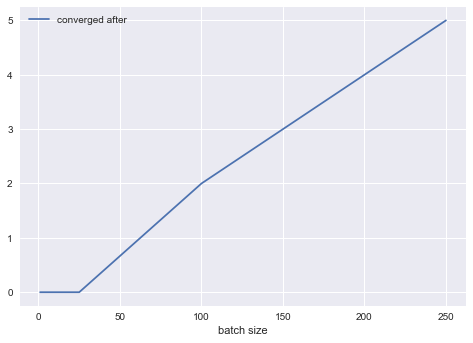

In [358]:
df[df['learning rate'] == 1].plot(y='converged after', x='batch size')

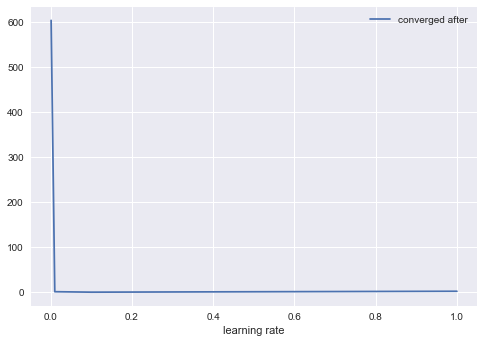

In [359]:
df[df['batch size'] == 100].plot(y='converged after', x='learning rate')

# Supervised learning

In [360]:
df = pd.DataFrame(columns=['batch size', 'learning rate', 'converged after', 'loss'])
for batch_size in [1, 10, 25, 100, 250]:
    for lr in [1, 1e-1, 1e-2, 1e-3]:   
        epoch, loss, agent = train(
            batch_size=10, 
            alphabet_size=10, 
            learning_rate=0.1,
            verbose=False,
            agent_class=DifferentiableAgent,
            world_class=DifferentiableWorld
        )
        df.loc[len(df)] = [batch_size, lr, epoch, loss.detach().numpy()]
df

,batch size,learning rate,converged after,loss
0,1,1,0,-0.0
1,1,0.1,0,-0.0
2,1,0.01,4,-0.0
3,1,0.001,1,-0.0
4,10,1,1,-0.0
5,10,0.1,0,-0.0
6,10,0.01,0,-0.0
7,10,0.001,0,-0.0
8,25,1,4,-0.0
9,25,0.1,0,-0.0


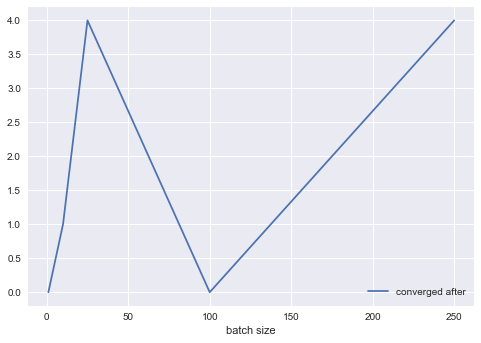

In [361]:
df[df['learning rate'] == 1].plot(y='converged after', x='batch size')

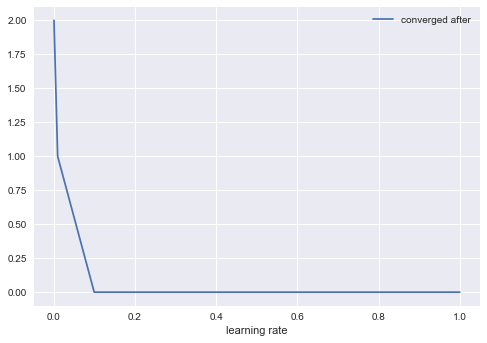

In [362]:
df[df['batch size'] == 100].plot(y='converged after', x='learning rate')

# Analyzing the codebook

In [363]:
def show_codebook(agent):
    return agent.policy.linear.weight.argmax(dim=1)

def is_codebook_injective(agent):
    return len(show_codebook(agent)) == len(set(show_codebook(agent)))

def visualize_codebook(agent):
    sns.heatmap(F.softmax(agent.policy.linear.weight, dim=1).detach().numpy(), annot=True, fmt='.1f')

In [364]:
for _ in range(10):
    epoch, loss, agent = train(
        batch_size=100, 
        alphabet_size=10, 
        learning_rate=0.1,
        verbose=False
    )
    print(epoch, show_codebook(agent), is_codebook_injective(agent))

999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True
999 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]) True


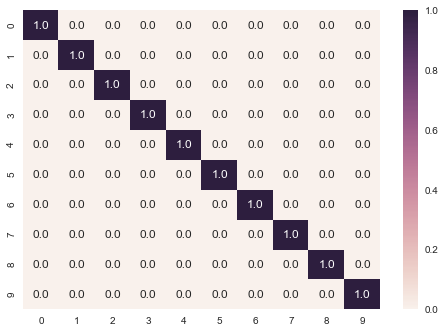

In [365]:
visualize_codebook(agent)

In [366]:
for _ in range(10):
    epoch, loss, agent = train(
        batch_size=100, 
        alphabet_size=50, 
        learning_rate=0.1,
        verbose=False
    )
    print(epoch, show_codebook(agent), is_codebook_injective(agent))

1 tensor([  0,  44,  30,  18,  33,  30,   6,  29,  37,  44,  43,  42,
          6,  16,   9,  43,  22,  13,  43,  46,  24,  32,  26,  23,
         47,  27,  19,  45,  29,  28,  22,  41,   0,  15,  39,  11,
         12,  33,  33,  23,  42,  28,   1,   1,  24,  37,  35,  20,
         38,  42]) True
13 tensor([ 27,   8,   2,  40,  28,   0,   6,  16,  48,  41,  41,  27,
         27,   5,  21,  25,  20,  10,  13,  41,  19,  16,   6,  44,
         46,  32,   7,  27,  17,  28,  41,   1,   1,  33,  17,   4,
         21,  46,  27,   2,  28,  42,   8,  23,   2,  42,  32,   7,
         17,  18]) True
1 tensor([  5,  17,  49,  27,  32,  20,  26,  35,  19,  46,  15,   4,
         19,   9,  20,  32,   3,  38,   9,  44,  23,  32,  42,  49,
         38,  48,  49,   2,  44,  24,  45,  26,  34,  38,  41,   1,
         34,   8,   1,  47,  13,  25,  35,  26,   8,  25,  38,  22,
         36,  13]) True
4 tensor([ 22,  26,  41,   9,   5,  19,  12,  14,  10,  20,  31,  18,
         38,   3,  11,  15,  39,  1

Only for larger alphabets the policy is encoded by a non-diagonal matrix.